In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

# titanic data

Najpierw zaloguj się do https://www.kaggle.com/ i przejdź do wyzwania https://www.kaggle.com/c/titanic, aby pobrać 
 * train.csv i test.csv. 

Zapisz je w katalogu datasets/titanic.

In [2]:
import os

TITANIC_PATH = os.path.join("datasets", "titanic")

In [3]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [4]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

* Dane są już podzielone na zestaw treningowy i zestaw testów. 
* Jednak dane testowe nie zawierają etykiet: Twoim celem jest wyszkolenie najlepszego modelu, który możesz wykorzystać w danych treningowych, następnie dokonanie swoich przewidywań na danych testowych i przesłanie ich do Kaggle, aby zobaczyć ostateczny wynik.

Rzućmy okiem na kilka pierwszych rzędów zestawu treningowego:

In [59]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The attributes have the following meaning:

* Survived: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* Pclass: passenger class.
* Name, Sex, Age: self-explanatory
* SibSp: how many siblings & spouses of the passenger aboard the Titanic.
* Parch: how many children & parents of the passenger aboard the Titanic.
* Ticket: ticket id
* Fare: price paid (in pounds)
* Cabin: passenger's cabin number
* Embarked: where the passenger embarked the Titanic
* Let's get more info to see how much data is missing:

In [60]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Atrybuty **Age**, **Cabin** oraz **Embarked** są czasami zerowe (mniej niż 891 wartości bez wartości null), szczególnie w przypadku **Cabin** (77% ma wartość zerową). Zignorujemy teraz **Cabin** i skupimy się na reszcie. Atrybut **Age** ma około 19% wartości pustych, więc będziemy musieli zdecydować, co z nimi zrobić. Zastąpienie wartości null medianą wieku wydaje się uzasadnione.

Atrybuty **Name** i **Ticket** mogą mieć pewną wartość, ale będą one nieco trudne do przekształcenia w użyteczne liczby. Na razie będziemy je ignorować.

Rzućmy okiem na atrybuty liczbowe:

In [61]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* Tylko 38% przeżyło: to wystarczająco blisko do 40%, więc **accuracy** będzie rozsądną miarą do oceny naszego modelu.

Sprawdźmy, czy etykiety przyjmują wartości 0 lub 1:

In [62]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

Nie zapomnij o etykietach:

In [17]:
y_train = train_data["Survived"]

In [18]:
train_data = train_data.drop("Survived",axis=1)
train_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
6,7,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
718,719,3,"McEvoy, Mr. Michael",male,NaN,0,0,36568,15.5000,NaN,Q
685,686,2,"Laroche, Mr. Joseph Philippe Lemercier",male,25.0,1,2,SC/Paris 2123,41.5792,NaN,C
73,74,3,"Chronopoulos, Mr. Apostolos",male,26.0,1,0,2680,14.4542,NaN,C
882,883,3,"Dahlberg, Miss. Gerda Ulrika",female,22.0,0,0,7552,10.5167,NaN,S


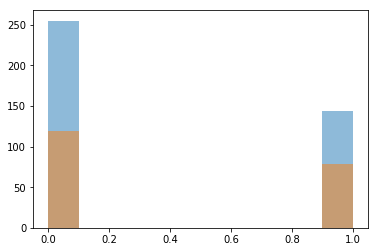

In [19]:
from sklearn.model_selection import train_test_split
train_data, X_test, y_train, y_test = train_test_split(train_data, y_train, test_size=0.20, random_state=42)

plt.hist(y_train, alpha=0.5)
plt.hist(y_test, alpha=0.5)
plt.show()

Teraz rzućmy okiem na wszystkie atrybuty kategoryczne:

In [85]:
train_data["Pclass"].value_counts()

3    336
1    135
2    125
Name: Pclass, dtype: int64

In [86]:
train_data["Sex"].value_counts()

male      390
female    206
Name: Sex, dtype: int64

In [87]:
train_data["Embarked"].value_counts()

S    437
C    105
Q     53
Name: Embarked, dtype: int64

Atrybut **Embarked** mówi nam, gdzie pasażer zaokrętował: C = Cherbourg, Q = Queenstown, S = Southampton.

Teraz zbudujmy nasze **pipeline** preprocessingu. 

Wykorzystamy DataframeSelector aby wybrać określone atrybuty z DataFrame:

In [88]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

Zbudujmy **pipeline** dla atrybutów numerycznych:

In [89]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer

# imputer = Imputer(strategy="median")

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
        ("imputer", Imputer(strategy="median")),
    ])

In [90]:
# num_pipeline.fit_transform(train_data)

array([[ 54.    ,   0.    ,   0.    ,  51.8625],
       [ 28.    ,   0.    ,   0.    ,  15.5   ],
       [ 25.    ,   1.    ,   2.    ,  41.5792],
       ...,
       [ 41.    ,   2.    ,   0.    ,  14.1083],
       [ 14.    ,   1.    ,   2.    , 120.    ],
       [ 21.    ,   0.    ,   1.    ,  77.2875]])

Będziemy także potrzebować imputera do kategorycznych kolumn  napisowych (zwykły Imputer nie działa na tych kolumnach):

In [91]:
# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

Teraz możemy zbudować **pipeline** dla atrybutów kategorycznych:

In [92]:
from future_encoders import OneHotEncoder

cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked", "Cabin"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [93]:
cat_pipeline.fit_transform(train_data)

array([[1., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.]])

Na koniec połączmy powyższe podejścia:

In [94]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

Teraz mamy fajny **pipeline** przetwarzania wstępnego, który pobiera dane wejściowe i zwraca dane wyjściowe złorzone z liczb, które możemy podać do dowolnego modelu uczenia maszynowego.

In [95]:
from sklearn.model_selection import StratifiedKFold

seed=123
kfold = StratifiedKFold(n_splits=5, random_state=seed)

In [96]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

pipe = Pipeline([('preprocessing', preprocess_pipeline), ('classifier', LinearSVC(C=1))])

param_grid = {
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_1 = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True)

grid_1.fit(train_data, y_train)
grid_1.best_params_

{'classifier__C': 0.01}

In [105]:
from sklearn.svm import SVC

pipe_2 = Pipeline([('preprocessing', preprocess_pipeline), ('classifier', SVC(C=1))])

param_grid_2 = {
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
            'classifier__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
}

grid_2 = GridSearchCV(pipe_2, param_grid_2, cv=kfold, return_train_score=True)

grid_2.fit(train_data, y_train)
grid_2.best_params_

{'classifier__C': 100, 'classifier__gamma': 0.001}

In [98]:
from sklearn.linear_model import LogisticRegression

pipe_3 = Pipeline([('preprocessing', preprocess_pipeline), ('classifier', LogisticRegression(C=1))])

param_grid_3 = {
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_3 = GridSearchCV(pipe_3, param_grid_3, cv=kfold, return_train_score=True)

grid_3.fit(train_data, y_train)
grid_3.best_params_

{'classifier__C': 1}

In [99]:
# y_train

In [106]:
from sklearn import  metrics


models = []
models.append(('SVM linear', grid_1.best_estimator_))
models.append(('SVM rbf', grid_2.best_estimator_))
models.append(('LR', grid_3.best_estimator_))


precision_score = []
recall_score = []
f1_score = []
accuracy_score = []
for name, model in models:
    print(name)
    print("precision_score: {}".format(metrics.precision_score(y_test , model.predict(X_test)) ))
    print("recall_score: {}".format( metrics.recall_score(y_test , model.predict(X_test)) ))
    print("f1_score: {}".format( metrics.f1_score(y_test , model.predict(X_test)) ))
    print("accuracy_score: {}".format( metrics.accuracy_score(y_test , model.predict(X_test)) ))
    precision_score.append(metrics.precision_score(y_test , model.predict(X_test)))
    recall_score.append(metrics.recall_score(y_test , model.predict(X_test)))
    f1_score.append( metrics.f1_score(y_test , model.predict(X_test)))
    accuracy_score.append(metrics.accuracy_score(y_test , model.predict(X_test)))

SVM linear
precision_score: 0.7961165048543689
recall_score: 0.6833333333333333
f1_score: 0.73542600896861
accuracy_score: 0.8
SVM rbf
precision_score: 0.8
recall_score: 0.7
f1_score: 0.7466666666666666
accuracy_score: 0.8067796610169492
LR
precision_score: 0.8018867924528302
recall_score: 0.7083333333333334
f1_score: 0.7522123893805309
accuracy_score: 0.8101694915254237


In [107]:
import pandas as pd
d = {'precision_score': precision_score, 
     'recall_score': recall_score, 
     'f1_score': f1_score,
     'accuracy_score' : accuracy_score
    }
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=['SVM linear','SVM rbf','LR'])
df

,Method,accuracy_score,f1_score,precision_score,recall_score
0,SVM linear,0.800000,0.735426,0.796117,0.683333
1,SVM rbf,0.806780,0.746667,0.800000,0.700000
2,LR,0.810169,0.752212,0.801887,0.708333
